<a href="https://colab.research.google.com/github/KIRTIRAJ4327/ML/blob/main/assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CNN-Based GAN Implementation - Assignment 8
# Student Name: [Your Name]
# Student ID: [Your ID]
# Platform: Google Colab

import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import uuid

# Check if we're in Colab and set up accordingly
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab ✓")
except:
    IN_COLAB = False
    print("Running locally")

Running in Google Colab ✓


In [2]:
# =============================================================================
# CONFIGURATION VARIABLES
# =============================================================================

# Configurable variables
NUM_EPOCHS = 30  # Minimum 30 epochs as required
NOISE_DIMENSION = 100  # Increased for better CNN performance
BATCH_SIZE = 128
TRAIN_ON_GPU = True
UNIQUE_RUN_ID = str(uuid.uuid4())
PRINT_STATS_AFTER_BATCH = 50
OPTIMIZER_LR = 0.0002
OPTIMIZER_BETAS = (0.5, 0.999)
IMAGE_SIZE = 28
IMAGE_CHANNELS = 1

In [3]:
 # =============================================================================
# PYTORCH SPEEDUPS
# =============================================================================

# Speed ups
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True


In [4]:
# =============================================================================
# CNN GENERATOR CLASS
# =============================================================================

class CNNGenerator(nn.Module):
    """
    CNN-based Generator for GAN
    Converts noise vector to image using transpose convolutions
    """
    def __init__(self, noise_dim=NOISE_DIMENSION):
        super(CNNGenerator, self).__init__()

        # Initial dense layer to reshape noise
        self.noise_dim = noise_dim

        # Calculate the initial size after first linear layer
        # We'll start with 7x7 feature maps with 256 channels
        self.init_size = 7
        self.init_channels = 256

        # Linear layer to expand noise to initial feature map
        self.linear = nn.Sequential(
            nn.Linear(noise_dim, self.init_channels * self.init_size * self.init_size),
            nn.BatchNorm1d(self.init_channels * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        # CNN layers using transpose convolutions for upsampling
        self.conv_blocks = nn.Sequential(
            # First upsampling: 7x7 -> 14x14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Second upsampling: 14x14 -> 28x28
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Final layer to get single channel output
            nn.ConvTranspose2d(64, IMAGE_CHANNELS, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output values in [-1, 1]
        )

    def forward(self, noise):
        # Reshape noise through linear layer
        out = self.linear(noise)
        out = out.view(out.shape[0], self.init_channels, self.init_size, self.init_size)

        # Apply CNN layers
        img = self.conv_blocks(out)
        return img


In [5]:
# =============================================================================
# CNN DISCRIMINATOR CLASS
# =============================================================================

class CNNDiscriminator(nn.Module):
    """
    CNN-based Discriminator for GAN
    Classifies images as real or fake using convolutional layers
    """
    def __init__(self):
        super(CNNDiscriminator, self).__init__()

        # CNN feature extraction layers
        self.conv_blocks = nn.Sequential(
            # First conv block: 28x28 -> 14x14
            nn.Conv2d(IMAGE_CHANNELS, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Second conv block: 14x14 -> 7x7
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Third conv block: 7x7 -> 3x3
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Fourth conv block: 3x3 -> 1x1
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        features = self.conv_blocks(img)
        validity = self.classifier(features)
        return validity

In [6]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def get_device():
    """Retrieve device based on settings and availability."""
    return torch.device("cuda:0" if torch.cuda.is_available() and TRAIN_ON_GPU else "cpu")

def make_directory_for_run():
    """Make a directory for this training run."""
    print(f'Preparing training run {UNIQUE_RUN_ID}')

    # In Colab, create directories in the current working directory
    base_dir = '/content' if IN_COLAB else '.'
    runs_dir = os.path.join(base_dir, 'runs')

    if not os.path.exists(runs_dir):
        os.makedirs(runs_dir)

    run_dir = os.path.join(runs_dir, UNIQUE_RUN_ID)
    os.makedirs(run_dir, exist_ok=True)

    return run_dir

def generate_image(generator, epoch=0, batch=0, device=get_device()):
    """Generate subplots with generated examples."""
    # Comment out this function to speed up training as mentioned in assignment
    # Uncomment the code below if you want to save images during training

    # images = []
    # noise = generate_noise(16, device=device)
    # generator.eval()
    # with torch.no_grad():
    #     images = generator(noise)
    #
    # plt.figure(figsize=(10, 10))
    # for i in range(16):
    #     # Get image and convert to numpy
    #     image = images[i].cpu().detach().numpy()
    #     image = np.transpose(image, (1, 2, 0))  # CHW -> HWC
    #     image = (image + 1) / 2.0  # Denormalize from [-1,1] to [0,1]
    #
    #     # Plot
    #     plt.subplot(4, 4, i+1)
    #     plt.imshow(image.squeeze(), cmap='gray')
    #     plt.axis('off')
    #
    # if not os.path.exists(f'./runs/{UNIQUE_RUN_ID}/images'):
    #     os.mkdir(f'./runs/{UNIQUE_RUN_ID}/images')
    # plt.savefig(f'./runs/{UNIQUE_RUN_ID}/images/epoch{epoch}_batch{batch}.jpg')
    # plt.close()
    # generator.train()

    pass  # Function disabled for speed as per assignment instructions

def save_models(generator, discriminator, epoch):
    """Save models at specific point in time."""
    base_dir = '/content' if IN_COLAB else '.'
    run_dir = os.path.join(base_dir, 'runs', UNIQUE_RUN_ID)

    torch.save(generator.state_dict(), os.path.join(run_dir, f'generator_{epoch}.pth'))
    torch.save(discriminator.state_dict(), os.path.join(run_dir, f'discriminator_{epoch}.pth'))

def print_training_progress(batch, generator_loss, discriminator_loss):
    """Print training progress."""
    print('Losses after mini-batch %5d: generator %e, discriminator %e' %
          (batch, generator_loss, discriminator_loss))

def prepare_dataset():
    """Prepare dataset through DataLoader"""
    # In Colab, download to /content/data
    data_dir = '/content/data' if IN_COLAB else os.getcwd()

    # Prepare MNIST dataset
    dataset = MNIST(data_dir, download=True, train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ]))

    # Batch and shuffle data with DataLoader
    # Reduce num_workers for Colab compatibility
    num_workers = 2 if IN_COLAB else 4

    trainloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    return trainloader

def initialize_models(device=get_device()):
    """Initialize Generator and Discriminator models"""
    generator = CNNGenerator()
    discriminator = CNNDiscriminator()

    # Move models to specific device
    generator.to(device)
    discriminator.to(device)

    # Initialize weights
    generator.apply(weights_init)
    discriminator.apply(weights_init)

    return generator, discriminator

def weights_init(m):
    """Initialize network weights"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def initialize_loss():
    """Initialize loss function."""
    return nn.BCELoss()

def initialize_optimizers(generator, discriminator):
    """Initialize optimizers for Generator and Discriminator."""
    generator_optimizer = torch.optim.Adam(
        generator.parameters(),
        lr=OPTIMIZER_LR,
        betas=OPTIMIZER_BETAS
    )
    discriminator_optimizer = torch.optim.Adam(
        discriminator.parameters(),
        lr=OPTIMIZER_LR,
        betas=OPTIMIZER_BETAS
    )
    return generator_optimizer, discriminator_optimizer

def generate_noise(number_of_images=1, noise_dimension=NOISE_DIMENSION, device=None):
    """Generate noise for number_of_images images, with a specific noise_dimension"""
    return torch.randn(number_of_images, noise_dimension, device=device)

def efficient_zero_grad(model):
    """
    Apply zero_grad more efficiently
    """
    for param in model.parameters():
        param.grad = None


In [7]:
# =============================================================================
# TRAINING FUNCTIONS
# =============================================================================

def perform_train_step(generator, discriminator, real_data,
                      loss_function, generator_optimizer, discriminator_optimizer,
                      device=get_device()):
    """Perform a single training step."""

    # 1. PREPARATION
    real_label, fake_label = 1.0, 0.0
    real_images = real_data[0].to(device)
    actual_batch_size = real_images.size(0)

    # 2. TRAINING THE DISCRIMINATOR
    efficient_zero_grad(discriminator)

    # Train with real images
    label = torch.full((actual_batch_size, 1), real_label, device=device, dtype=torch.float)
    real_output = discriminator(real_images)
    error_real = loss_function(real_output, label)
    error_real.backward()

    # Train with fake images
    noise = generate_noise(actual_batch_size, device=device)
    fake_images = generator(noise)
    label.fill_(fake_label)
    fake_output = discriminator(fake_images.detach())
    error_fake = loss_function(fake_output, label)
    error_fake.backward()

    discriminator_optimizer.step()

    # 3. TRAINING THE GENERATOR
    efficient_zero_grad(generator)
    label.fill_(real_label)  # We want generator to fool discriminator
    output = discriminator(fake_images)
    error_generator = loss_function(output, label)
    error_generator.backward()
    generator_optimizer.step()

    # 4. COMPUTING RESULTS
    error_discriminator = error_real.item() + error_fake.item()

    return error_generator.item(), error_discriminator

def perform_epoch(dataloader, generator, discriminator, loss_function,
                 generator_optimizer, discriminator_optimizer, epoch):
    """Perform a single epoch."""
    for batch_no, real_data in enumerate(dataloader, 0):
        # Perform training step
        generator_loss_val, discriminator_loss_val = perform_train_step(
            generator, discriminator, real_data, loss_function,
            generator_optimizer, discriminator_optimizer
        )

        # Print statistics and generate image after every n-th batch
        if batch_no % PRINT_STATS_AFTER_BATCH == 0:
            print_training_progress(batch_no, generator_loss_val, discriminator_loss_val)
            generate_image(generator, epoch, batch_no)

    # Save models on epoch completion
    save_models(generator, discriminator, epoch)

    # Clear memory after every epoch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def train_cnn_gan():
    """Train the CNN-based GAN."""
    # Make directory for unique run
    run_dir = make_directory_for_run()

    # Set fixed random number seed for reproducibility
    torch.manual_seed(42)

    # Get device info
    device = get_device()
    print(f"Training on device: {device}")

    # In Colab, check GPU availability
    if IN_COLAB:
        print(f"GPU available: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"GPU name: {torch.cuda.get_device_name(0)}")
            print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Get prepared dataset
    dataloader = prepare_dataset()

    # Initialize models
    generator, discriminator = initialize_models(device)

    # Print model architectures
    print("\n=== Generator Architecture ===")
    print(generator)
    print(f"\nGenerator parameters: {sum(p.numel() for p in generator.parameters()):,}")

    print("\n=== Discriminator Architecture ===")
    print(discriminator)
    print(f"\nDiscriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

    # Initialize loss and optimizers
    loss_function = initialize_loss()
    generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator)

    # Training loop
    print(f"\n=== Starting Training for {NUM_EPOCHS} Epochs ===")

    # Lists to store losses for plotting
    generator_losses = []
    discriminator_losses = []

    for epoch in range(NUM_EPOCHS):
        print(f'\nStarting epoch {epoch+1}/{NUM_EPOCHS}...')

        epoch_gen_losses = []
        epoch_disc_losses = []

        for batch_no, real_data in enumerate(dataloader, 0):
            # Perform training step
            gen_loss, disc_loss = perform_train_step(
                generator, discriminator, real_data, loss_function,
                generator_optimizer, discriminator_optimizer, device
            )

            epoch_gen_losses.append(gen_loss)
            epoch_disc_losses.append(disc_loss)

            # Print statistics
            if batch_no % PRINT_STATS_AFTER_BATCH == 0:
                print_training_progress(batch_no, gen_loss, disc_loss)

        # Save average losses for this epoch
        avg_gen_loss = np.mean(epoch_gen_losses)
        avg_disc_loss = np.mean(epoch_disc_losses)
        generator_losses.append(avg_gen_loss)
        discriminator_losses.append(avg_disc_loss)

        print(f'Epoch {epoch+1} completed. Avg Generator Loss: {avg_gen_loss:.6f}, Avg Discriminator Loss: {avg_disc_loss:.6f}')

        # Save models every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_models(generator, discriminator, epoch)

        # Clear memory after every epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Save final models
    save_models(generator, discriminator, NUM_EPOCHS-1)

    # Plot training losses
    plot_training_losses(generator_losses, discriminator_losses)

    # Generate final sample images
    generate_final_samples(generator, device)

    print(f'\nFinished training! Results saved in {run_dir}')

    # In Colab, show how to download results
    if IN_COLAB:
        print("\n=== Download Instructions for Colab ===")
        print("1. Files are saved in /content/runs/[run_id]/")
        print("2. Use the file browser on the left to navigate and download")
        print("3. Or use: !zip -r results.zip /content/runs")
        print("4. Then download results.zip from the Files panel")

def plot_training_losses(generator_losses, discriminator_losses):
    """Plot training losses over epochs."""
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss', color='blue')
    plt.plot(discriminator_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True)

    # Save plot
    base_dir = '/content' if IN_COLAB else '.'
    run_dir = os.path.join(base_dir, 'runs', UNIQUE_RUN_ID)
    plt.savefig(os.path.join(run_dir, 'training_losses.png'))
    plt.show()

def generate_final_samples(generator, device):
    """Generate final sample images to showcase results."""
    generator.eval()

    with torch.no_grad():
        # Generate 16 sample images
        noise = generate_noise(16, device=device)
        generated_images = generator(noise)

        # Create a grid of images
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i in range(16):
            img = generated_images[i].cpu().numpy()
            img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
            img = (img + 1) / 2.0  # Denormalize from [-1,1] to [0,1]

            row, col = i // 4, i % 4
            axes[row, col].imshow(img.squeeze(), cmap='gray')
            axes[row, col].axis('off')

        plt.suptitle('Generated MNIST Digits - Final Results')
        plt.tight_layout()

        # Save plot
        base_dir = '/content' if IN_COLAB else '.'
        run_dir = os.path.join(base_dir, 'runs', UNIQUE_RUN_ID)
        plt.savefig(os.path.join(run_dir, 'final_generated_samples.png'))
        plt.show()

    generator.train()


=== CNN-Based GAN Implementation - Assignment 8 ===
Converting feedforward networks to CNNs as required...
Configuration: 30 epochs, batch size 128
Preparing training run f7a4029a-7e4b-4190-a858-07c73082edca
Training on device: cuda:0
GPU available: True
GPU name: Tesla T4
GPU memory: 15.8 GB


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.62MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.57MB/s]



=== Generator Architecture ===
CNNGenerator(
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_blocks): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

Generator parameters: 1,948,545

=== Discriminator Architecture ===
CNNDiscriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Lea

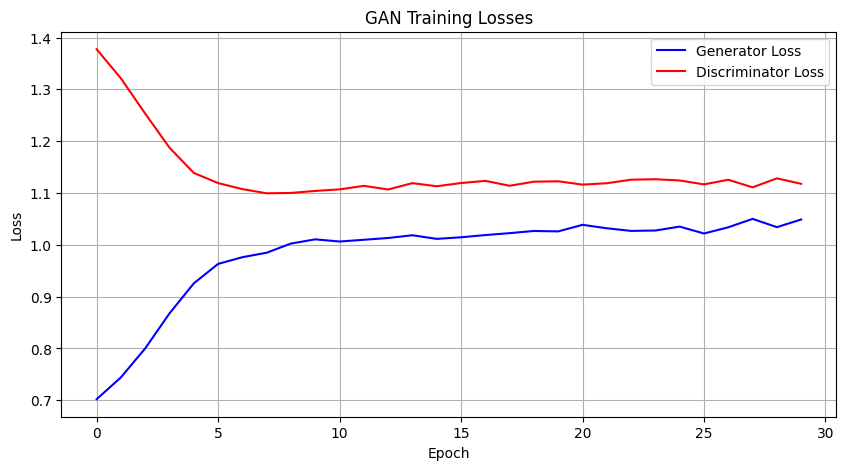

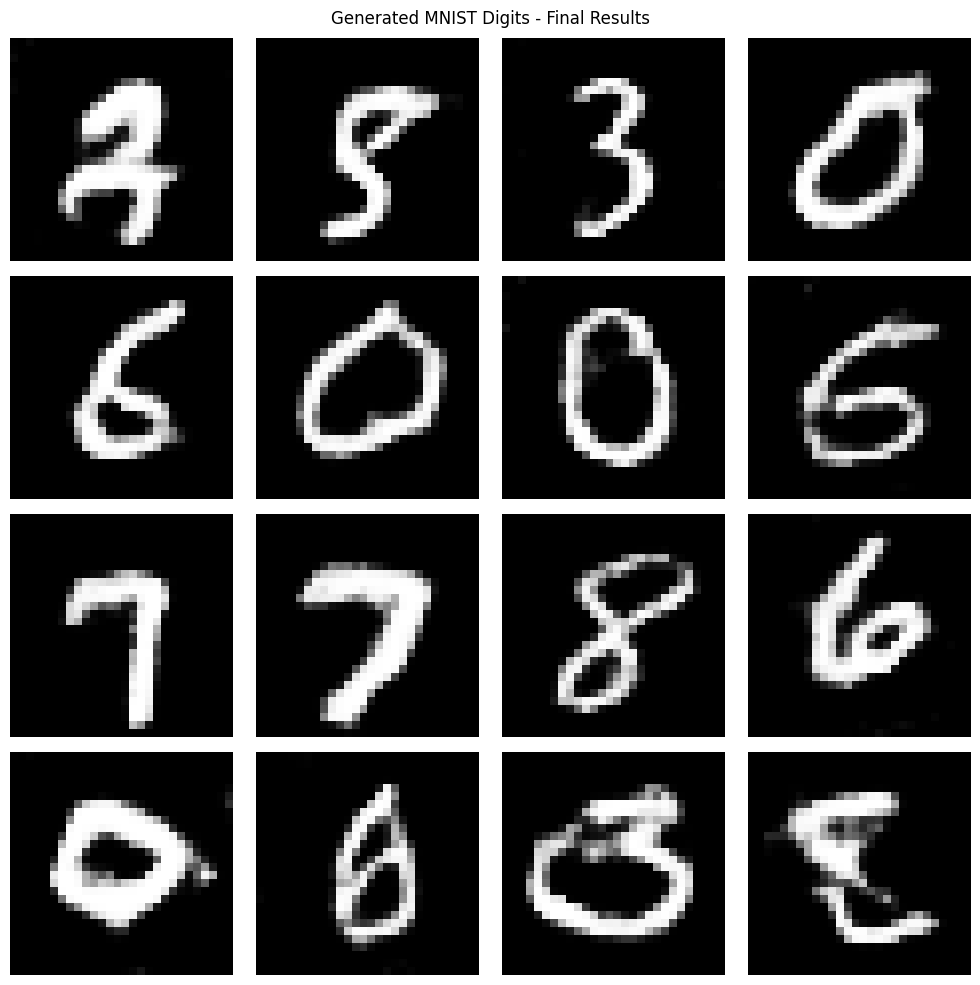


Finished training! Results saved in /content/runs/f7a4029a-7e4b-4190-a858-07c73082edca

=== Download Instructions for Colab ===
1. Files are saved in /content/runs/[run_id]/
2. Use the file browser on the left to navigate and download
3. Or use: !zip -r results.zip /content/runs
4. Then download results.zip from the Files panel


In [8]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == '__main__':
    print("=== CNN-Based GAN Implementation - Assignment 8 ===")
    print("Converting feedforward networks to CNNs as required...")
    print(f"Configuration: {NUM_EPOCHS} epochs, batch size {BATCH_SIZE}")

    train_cnn_gan()